<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [1]:
import re
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
from spacy.tokenizer import Tokenizer
from bs4 import BeautifulSoup



## 1) *Clean:* Job Listings from indeed.com that contain the title "Data Scientist" 

You have `job_listings.csv` in the data folder for this module. The text data in the description column is still messy - full of html tags. Use the [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library to clean up this column. You will need to read through the documentation to accomplish this task. 

In [2]:
from bs4 import BeautifulSoup
import requests                
import pandas as pd

df= pd.read_csv('./data/job_listings.csv', index_col=0)

In [3]:
def clean_description(desc):
    soup = BeautifulSoup(desc)
    return soup.get_text()
df['clean_desc'] = df['description'].apply(clean_description)
df

,description,title,clean_desc
0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist,"b""Job Requirements:\nConceptual understanding ..."
1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I,"b'Job Description\n\nAs a Data Scientist 1, yo..."
2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level,b'As a Data Scientist you will be working on c...
3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist,"b'$4,969 - $6,756 a monthContractUnder the gen..."
4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist,b'Location: USA \xe2\x80\x93 multiple location...
...,...,...,...
421,"b""<b>About Us:</b><br/>\nWant to be part of a ...",Senior Data Science Engineer,"b""About Us:\nWant to be part of a fantastic an..."
422,"b'<div class=""jobsearch-JobMetadataHeader icl-...",2019 PhD Data Scientist Internship - Forecasti...,"b'InternshipAt Uber, we ignite opportunity by ..."
423,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist - Insurance,"b'$200,000 - $350,000 a yearA million people a..."
424,"b""<p></p><div><p>SENIOR DATA SCIENTIST</p><p>\...",Senior Data Scientist,"b""SENIOR DATA SCIENTIST\nJOB DESCRIPTION\n\nAB..."


In [4]:
# Prepping upcoming string split
clean = df['clean_desc'].tolist()
clean[0]

'b"Job Requirements:\\nConceptual understanding in Machine Learning models like Nai\\xc2\\xa8ve Bayes, K-Means, SVM, Apriori, Linear/ Logistic Regression, Neural, Random Forests, Decision Trees, K-NN along with hands-on experience in at least 2 of them\\nIntermediate to expert level coding skills in Python/R. (Ability to write functions, clean and efficient data manipulation are mandatory for this role)\\nExposure to packages like NumPy, SciPy, Pandas, Matplotlib etc in Python or GGPlot2, dplyr, tidyR in R\\nAbility to communicate Model findings to both Technical and Non-Technical stake holders\\nHands on experience in SQL/Hive or similar programming language\\nMust show past work via GitHub, Kaggle or any other published article\\nMaster\'s degree in Statistics/Mathematics/Computer Science or any other quant specific field.\\nApply Now"'

In [5]:
# Drop the b at the start of every description
df['clean_desc'] = [s.split("b", 1)[-1] for s in clean]
df['clean_desc']

0      "Job Requirements:\nConceptual understanding i...
1      'Job Description\n\nAs a Data Scientist 1, you...
2      'As a Data Scientist you will be working on co...
3      '$4,969 - $6,756 a monthContractUnder the gene...
4      'Location: USA \xe2\x80\x93 multiple locations...
                             ...                        
421    "About Us:\nWant to be part of a fantastic and...
422    'InternshipAt Uber, we ignite opportunity by s...
423    '$200,000 - $350,000 a yearA million people a ...
424    "SENIOR DATA SCIENTIST\nJOB DESCRIPTION\n\nABO...
425    'Cerner Intelligence is a new, innovative orga...
Name: clean_desc, Length: 426, dtype: object

## 2) Use Spacy to tokenize the listings 

In [6]:
# Instantiate spacy
nlp = spacy.load("en_core_web_lg")

# Create a blank Tokenizer with just the English vocab
tokenizer = Tokenizer(nlp.vocab)

# Tokenizer Pipe
tokens = []

""" Make them tokens """
for txt in tokenizer.pipe(df['clean_desc'], batch_size=500):
    txt_tokens = [token.text for token in txt]
    tokens.append(txt_tokens)
    
# Create new column in the df for tokens
df['tokens'] = tokens
df['tokens']

0      ["Job, Requirements:\nConceptual, understandin...
1      ['Job, Description\n\nAs, a, Data, Scientist, ...
2      ['As, a, Data, Scientist, you, will, be, worki...
3      ['$4,969, -, $6,756, a, monthContractUnder, th...
4      ['Location:, USA, \xe2\x80\x93, multiple, loca...
                             ...                        
421    ["About, Us:\nWant, to, be, part, of, a, fanta...
422    ['InternshipAt, Uber,, we, ignite, opportunity...
423    ['$200,000, -, $350,000, a, yearA, million, pe...
424    ["SENIOR, DATA, SCIENTIST\nJOB, DESCRIPTION\n\...
425    ['Cerner, Intelligence, is, a, new,, innovativ...
Name: tokens, Length: 426, dtype: object

## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [7]:
# Instantiate the transformer
vect = CountVectorizer(stop_words='english', min_df=2, max_df=.95, ngram_range=(1,2), max_features=5000)

#Learn our Vocab
vect.fit(df['clean_desc'])

# Get sparse dtm
dtm = vect.transform(df['clean_desc'])

# Get word counts for each listing
dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())
dtm

,000,000 employees,10,10 years,100,100 000,11,12,12 months,15,...,years related,years relevant,years work,years working,years xe2,yes,york,york city,yrs,zf
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
422,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
423,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
424,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 4) Visualize the most common word counts

In [8]:
row = dtm.mean(axis=1)
row

0      0.0190
1      0.0824
2      0.0196
3      0.0298
4      0.0064
        ...  
421    0.0884
422    0.0626
423    0.0562
424    0.0922
425    0.0934
Length: 426, dtype: float64

In [9]:
row.describe()

count    426.000000
mean       0.074343
std        0.037227
min        0.002600
25%        0.048950
50%        0.070000
75%        0.089950
max        0.396400
dtype: float64

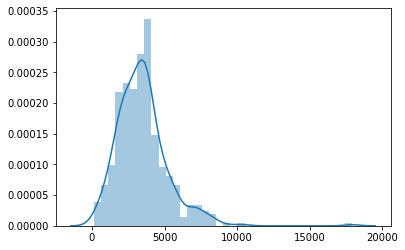

In [11]:
import seaborn as sns

doc_len = [len(doc) for doc in df['clean_desc']]
sns.distplot(doc_len);

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [18]:
# Use tokenize function for upcoming tfidf vectorizer
def tokenize(document):
    
    doc = nlp(document)
    
    return [token.lemma_.strip() for token in doc if (token.is_stop != True) and (token.is_punct != True)]

In [19]:
# Tunning Parameters

# Instantiate vectorizer object
tfidf = TfidfVectorizer(stop_words='english', 
                        ngram_range=(1,2),
                        max_df=.97,
                        min_df=2,
                        max_features=5000,
                        tokenizer=tokenize)

# Create a vocabulary and get word counts per document
dtm = tfidf.fit_transform(df['clean_desc']) # Similiar to fit_predict

# Get feature names to use as dataframe column headers
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

# View Feature Matrix as DataFrame
dtm.head()

,$,"$ 100,000",+,+ year,+ years\xe2\x80\x99,0,0 2,1,1 year,10,...,you\'ll,you\xe2\x80\x99ll,you\xe2\x80\x99ll work,you\xe2\x80\x99re,you\xe2\x80\x99re look,you\xe2\x80\x99ve,yrs,zf,|,||
0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.030565,0.033375,0.0,0.0,0.0,0.115252,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.246446,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.133049,0.145279,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [20]:
# Rough job description to be used in NN model
ideal = [
    """
    Transform data into a format that can be easily analyzed. Develop, maintain, and test infrastructures for data generation. Work closely with data scientists 
    and are largely in charge of architecting solutions for data scientists that enable them to do their jobs. Create and maintain optimal data pipeline architecture,
    assemble large, complex data sets that meet functional business requirements, SQL / NoSQL / querying databases.
    """
] 

In [25]:
from sklearn.neighbors import NearestNeighbors

# Instantiate model
nn = NearestNeighbors(n_neighbors=5, algorithm='ball_tree')

# Fit the model
nn.fit(dtm)

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [26]:
# Query the ideal job description
new = tfidf.transform(ideal)

# Find nearest neighbors
nn.kneighbors(new.todense())

(array([[1.21533238, 1.21545123, 1.33737225, 1.34156507, 1.34269026]]),
 array([[216, 217, 300, 251, 118]], dtype=int64))

In [28]:
# Inspect most relevant job
df['clean_desc'][216]

"'Overview\\nNewWave is an information technology company helping businesses and government agencies modernize and thrive by applying the power of technology. NewWave began making a mark in the federal healthcare space in 2004, where we continue to actively modernize systems to improve healthcare\\xe2\\x80\\x99s value for millions of Americans. Since then, our work has expanded across various sectors and industries, where we help our customers stay ahead of the new and make the world in which we live, better.\\nResponsibilities\\nWe are looking for a savvy Data Engineer to join our growing team. The hire will be responsible for expanding and optimizing our data and data pipeline architecture, as well as optimizing data flow and collection for cross functional teams. The ideal candidate is an experienced data pipeline builder and data wrangler who enjoys optimizing data systems and building them from the ground up. The Data Engineer will support our software developers, database archite

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 